# Objective (Problem Statement): To predict the area burned in the Forest Fire.

## Import Library

In [0]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split


pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting 4 decimal
plt.rcParams["figure.figsize"] = [9,5]
plt.style.use('ggplot')



## Load & Describe Dataset

### Load

In [0]:
data_df = pd.read_csv("forestfires.csv")

### First Five Rows

In [0]:
data_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2000,26.2000,94.3000,5.1000,8.2000,51,6.7000,0.0000,0.0000
1,7,4,oct,tue,90.6000,35.4000,669.1000,6.7000,18.0000,33,0.9000,0.0000,0.0000
2,7,4,oct,sat,90.6000,43.7000,686.9000,6.7000,14.6000,33,1.3000,0.0000,0.0000
3,8,6,mar,fri,91.7000,33.3000,77.5000,9.0000,8.3000,97,4.0000,0.2000,0.0000
4,8,6,mar,sun,89.3000,51.3000,102.2000,9.6000,11.4000,99,1.8000,0.0000,0.0000


#### Set Target Variable
We need to find area burned so we set target equals to area 

In [0]:
target = 'area' 

### Shape

In [0]:
data_df.shape

(517, 13)

### Data types

In [0]:
data_df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

We need to convert month and day to either `int` or `float` from object data type

### Feature Columns

In [0]:
data_df.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')

### Describe Dataset

In [0]:
data_df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000,517.0000
mean,4.6692,4.2998,90.6447,110.8723,547.9400,9.0217,18.8892,44.2882,4.0176,0.0217,12.8473
std,2.3138,1.2299,5.5201,64.0465,248.0662,4.5595,5.8066,16.3175,1.7917,0.2960,63.6558
min,1.0000,2.0000,18.7000,1.1000,7.9000,0.0000,2.2000,15.0000,0.4000,0.0000,0.0000
25%,3.0000,4.0000,90.2000,68.6000,437.7000,6.5000,15.5000,33.0000,2.7000,0.0000,0.0000
50%,4.0000,4.0000,91.6000,108.3000,664.2000,8.4000,19.3000,42.0000,4.0000,0.0000,0.5200
75%,7.0000,5.0000,92.9000,142.4000,713.9000,10.8000,22.8000,53.0000,4.9000,0.0000,6.5700
max,9.0000,9.0000,96.2000,291.3000,860.6000,56.1000,33.3000,100.0000,9.4000,6.4000,1090.8400


<p>As we can see count of every feature columns are same as shape of dataset. So we can say there is no missing data but we need to check to confirm. We will check later.</p>
<p>Wen can see 50% (the middle of the data) also called median of feature columns('X', 'Y', 'DMC', 'ISI', 'RH', 'wind', 'rain', 'area') have higher mean value than median i.e data is right skewed. In all feature columns, column: 'area' is highly skewed.    
</p>

#### How to handle right skewed data?
<p>Here data are right-skewed (clustered at lower values). We will perform operations like:- square root, cube root, logarithmic, etc. to transform the data. If the data are left-skewed (clustered at higher values). We will perform operations like:- cube, square, etc.</p>

## EDA(Explotary Data Analysis)

### Check missing values

In [0]:
# Calculating missing data in feature columns
data_mis = (data_df.isnull().sum() / len(data_df)) * 100
data_mis = data_mis.drop(data_mis[data_mis == 0].index).sort_values(ascending=False)
data_mis = pd.DataFrame({'Percentage' :data_mis})
data_mis['Id'] = data_mis.index
data_mis.reset_index(drop=True,level=0, inplace=True)
data_mis.head()

,Percentage,Id


No missing value is found in the dataset.

#### Numerical and & Categorical Columns

In [0]:
dft = data_df.drop(columns=target)
cate_columns = dft.select_dtypes(include='object').columns.tolist()
nume_columns = dft.select_dtypes(exclude='object').columns.tolist()

In [0]:
print('Categorical columns: ',cate_columns)
print('Numerical columns: ',nume_columns)

Categorical columns:  ['month', 'day']
Numerical columns:  ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


### Univariate Check

### Skewness & Kurtosis

In [0]:
print("Skew: \n{}".format(data_df.skew()))
print("Kurtosis: \n{}".format(data_df.kurtosis()))

Skew: 
X       0.0362
Y       0.4173
FFMC   -6.5756
DMC     0.5475
DC     -1.1004
ISI     2.5363
temp   -0.3312
RH      0.8629
wind    0.5710
rain   19.8163
area   12.8469
dtype: float64
Kurtosis: 
X       -1.1723
Y        1.4206
FFMC    67.0660
DMC      0.2048
DC      -0.2452
ISI     21.4580
temp     0.1362
RH       0.4382
wind     0.0543
rain   421.2960
area   194.1407
dtype: float64


<p>Skew is the degree of distortion from a normal distribution. skewed, meaning there are a minority of very large values.</p>
<p>Kurtosis is all about the tails of the distribution — not the peakedness or flatness. It is used to describe the extreme values in one versus the other tail. It is actually the measure of outliers present in the distribution . High kurtosis in a data set is an indicator that data has heavy tails or outliers.</p>

<p>If skewness is positive, the data are positively skewed or skewed right, meaning that the right tail of the distribution is longer than the left. If skewness is negative, the data are negatively skewed or skewed left, meaning that the left tail is longer.</p>

<ul>
    <li>If skewness is less than −1 or greater than +1, the distribution is highly skewed.</li>
    <li>If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.</li>
    <li>If skewness is between −½ and +½, the distribution is approximately symmetric.</li>
</ul>

<ul>
<li>A normal distribution has kurtosis exactly 3 (excess kurtosis exactly 0). Any distribution with kurtosis ≈3 (excess ≈0) is called mesokurtic.</li>
<li>A distribution with kurtosis &lt;3 (excess kurtosis &lt;0 ) is called platykurtic. Compared to a normal distribution, its tails are shorter and thinner, and often its central peak is lower and broader.</li>
<li>A distribution with kurtosis &gt;3 (excess kurtosis >0) is called leptokurtic. Compared to a normal distribution, its tails are longer and fatter, and often its central peak is higher and sharper.</li>
</ul>

<p>
<b> Feature columns:- 'ISI', & 'rain'  have +ve skewness, value more than +1 so, they are right skewed.</b>
</p>    

<p>
<b> Feature columns:- 'FFMC', & 'temp'  have -ve skewness, value less than -1 so, they are left skewed.</b>
</p>    

<p>
<b> Feature columns:- 'FFMC', 'ISI', & 'rain'  have higher kurtosis value. i,e have outliers.</b>
</p>    

Feature columns with (high, +ve, or -ve) outliers, skewness and kurtosis are: 
<ol>
<li>FFMC</li>
<li>ISI</li>
<li>rain</li>
</ol>

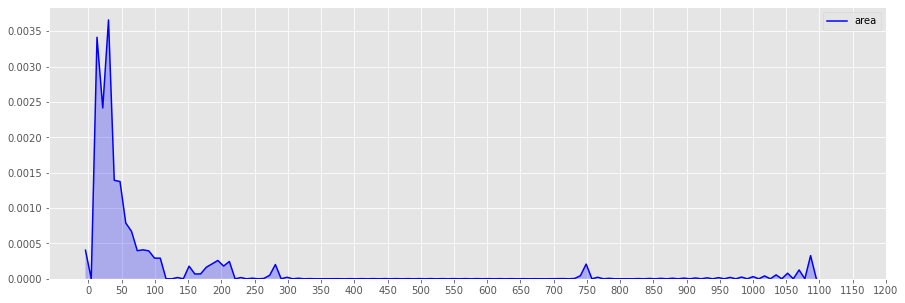

In [0]:
plt.figure(figsize=(15,5))
ax = sns.kdeplot(data_df[target],shade=True,color='b')
plt.xticks([i for i in range(0,1250,50)])
plt.show()

#### target i.e area is right skewed.

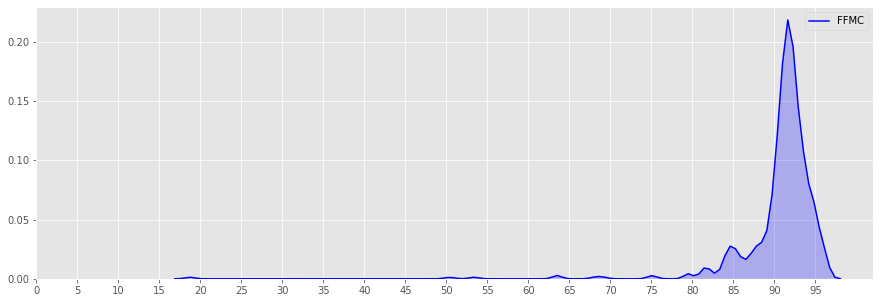

In [0]:
plt.figure(figsize=(15,5))
ax = sns.kdeplot(data_df['FFMC'],shade=True,color='b')
plt.xticks([i for i in range(0,100,5)])
plt.show()

#### FFMC is left skewed.

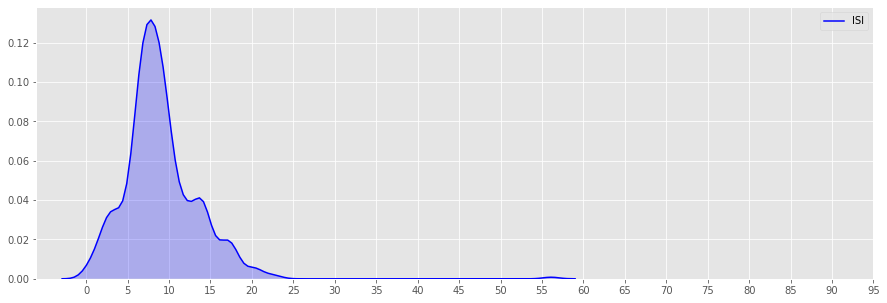

In [0]:
plt.figure(figsize=(15,5))
ax = sns.kdeplot(data_df['ISI'],shade=True,color='b')
plt.xticks([i for i in range(0,100,5)])
plt.show()


#### ISI is right skewed.

### Outliers

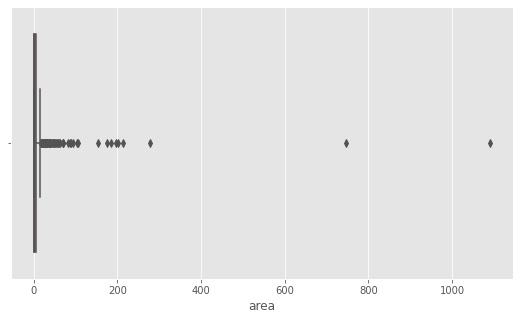

In [0]:
outl_dect = sns.boxplot(data_df[target])

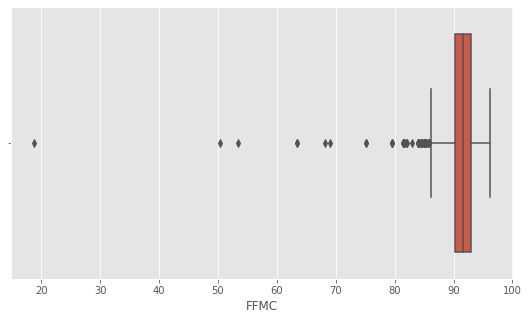

In [0]:
outl_dect = sns.boxplot(data_df['FFMC'])

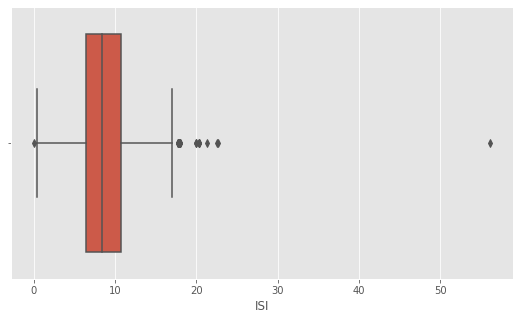

In [0]:
outl_dect = sns.boxplot(data_df['ISI'])

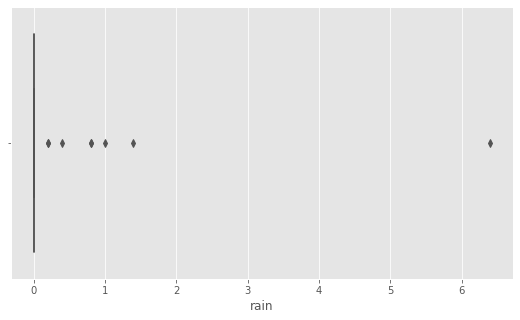

In [0]:
outl_dect = sns.boxplot(data_df['rain'])

### Outlier analysis

Outliers are found in the following columns:
<ol>
<li>area</li>
<li>FFMC</li>
<li>ISI</li>
<li>rain</li>
</ol>


<p>Instead of removing them we will transform the data to treat the outliers.</p>

In [0]:
outlier_columns = ['area','FFMC','ISI','rain']

In [0]:
np.log1p(data_df[outlier_columns]).skew()

area     1.2178
FFMC   -11.6754
ISI     -0.9372
rain    14.1730
dtype: float64

In [0]:
np.log1p(data_df[outlier_columns]).kurtosis()

area     0.9457
FFMC   185.4824
ISI      2.5846
rain   234.2400
dtype: float64

Even after transformation we still have high skewness and kurtosis in `FFMC` & `rain`

<p>Removing outliers by zscore method.</p>

In [0]:
mask = data_df.loc[:,['FFMC']].apply(zscore).abs() < 3

In [0]:
data_df = data_df[mask.values]
data_df.shape

(510, 13)

In [0]:
# Since most of the values in rain are 0.0, we can convert it as a categorical column
data_df['rain'] = data_df['rain'].apply(lambda x: int(x > 0.0))


In [0]:
outlier_columns.remove('rain')
data_df[outlier_columns] = np.log1p(data_df[outlier_columns])

In [0]:
data_df[outlier_columns].skew()

area    1.2085
FFMC   -1.8040
ISI    -0.4344
dtype: float64

In [0]:
data_df[outlier_columns].kurtosis() 

area   0.9234
FFMC   4.8667
ISI    1.1226
dtype: float64

In [0]:

data_df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000
mean,4.6804,4.2941,4.5226,111.8376,550.4704,2.2285,18.9516,44.0294,4.0173,0.0157,1.1214
std,2.3205,1.2346,0.0350,63.8537,246.6307,0.4288,5.7899,15.9683,1.7888,0.1244,1.4014
min,1.0000,2.0000,4.3320,3.0000,7.9000,0.7419,2.2000,15.0000,0.4000,0.0000,0.0000
25%,3.0000,4.0000,4.5142,73.2500,442.3000,2.0412,15.6250,32.2500,2.7000,0.0000,0.0000
50%,4.0000,4.0000,4.5288,108.4000,664.2000,2.2407,19.3000,41.5000,4.0000,0.0000,0.4572
75%,7.0000,5.0000,4.5422,142.4000,714.2000,2.4849,22.8000,53.0000,4.9000,0.0000,2.0252
max,9.0000,9.0000,4.5768,291.3000,860.6000,4.0448,33.3000,99.0000,9.4000,1.0000,6.9956


Dataset is ready for model preparation.

In [0]:
data_sel = data_df.copy()

## Applying xgboost

Encoding `day` & `month` column with label encoder

In [0]:
le = LabelEncoder() 
  
data_sel['day']= le.fit_transform(data_sel['day']) 
data_sel['month']= le.fit_transform(data_sel['month']) 

In [0]:
X, y = data_sel.iloc[:,:-1],data_sel.iloc[:,-1]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)


Dividing dataset into 33% test sample and 67% training sample .

In [0]:
#xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg = xgb.XGBRegressor(base_score=0.3, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.24, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=102,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)



In [0]:
#eval_set = [(X_test, y_test)]
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg.fit(X_train, y_train, eval_metric=["rmse"],eval_set=eval_set, verbose=False)
preds = xg_reg.predict(X_test)

#### verbose set to False so that we can hide results of model fit progress

In [0]:
def calc_ISE(X_train, y_train, model):
    '''returns the in-sample R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_train, y_train), rmse
    
def calc_OSE(X_test, y_test, model):
    '''returns the out-of-sample R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_test, y_test), rmse


**Calculate In-Sample and Out-of-Sample R^2 and Error**

In [0]:
is_r2, ise = calc_ISE(X_train, y_train,xg_reg )
os_r2, ose = calc_OSE(X_test, y_test, xg_reg)

# show dataset sizes
data_list = (('R^2_in', is_r2), ('R^2_out', os_r2), 
             ('ISE', ise), ('OSE', ose))
for item in data_list:
    print('{:10}: {}'.format(item[0], item[1]))

R^2_in    : 0.04298652222055299
R^2_out   : -0.015935882283006464
ISE       : 1.3822183772150034
OSE       : 1.3821543637297975


**Clearly test error(OSE) is near to the training error(ISE). i.e our model is ok.
**

In [0]:
print('train/test: ',ose/ise)

train/test:  0.9999536878641891


In [0]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


RMSE: 1.382154


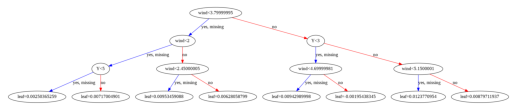

In [0]:
xgb.plot_tree(xg_reg,num_trees=0)

plt.rcParams['figure.figsize'] = [15, 15]
plt.show()


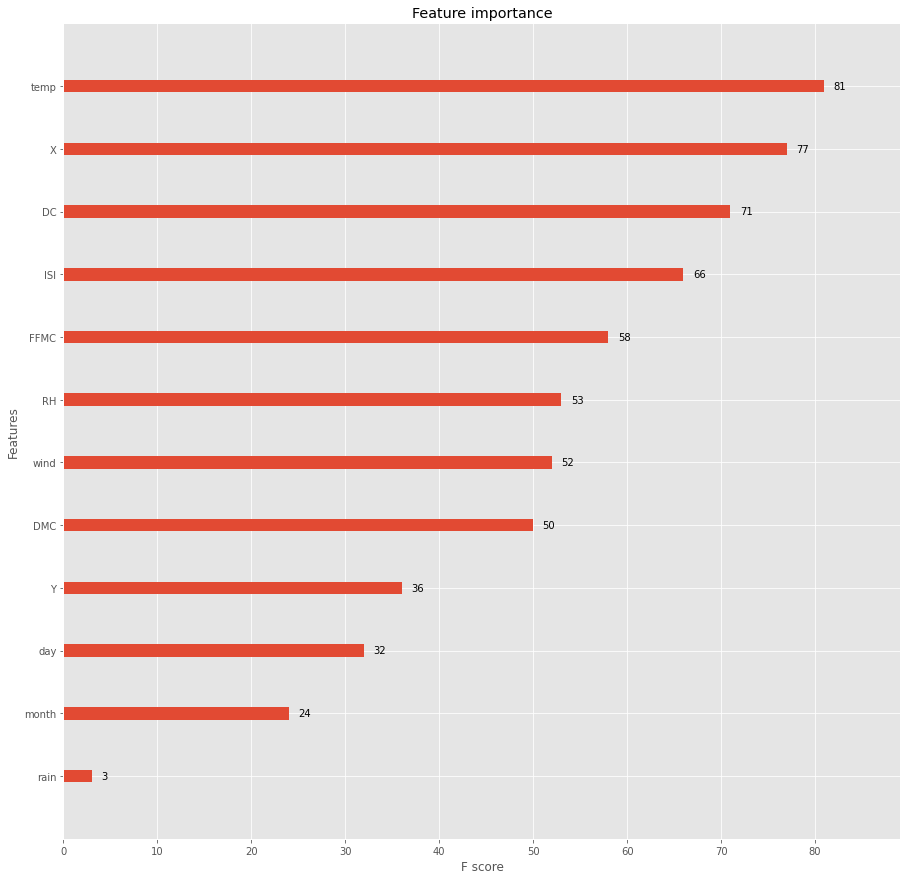

In [0]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [7, 7]
plt.show()


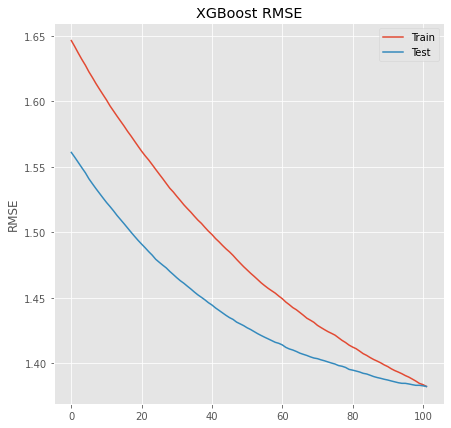

In [0]:
# retrieve performance metrics
results = xg_reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot RMSE
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [0]:
xg_reg.save_model('0001.model_forest_fire')


In [0]:
X_test

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
365,6,5,11,5,4.5315,111.7000,770.3000,2.0149,19.6000,45,3.1000,0
463,6,5,3,5,4.3320,4.4000,16.2000,1.0647,4.6000,82,6.3000,0
333,1,4,11,1,4.5337,87.7000,721.1000,2.3514,18.1000,54,3.1000,0
14,6,5,11,6,4.5422,133.3000,699.6000,2.3224,26.4000,21,4.5000,0
428,1,3,1,4,4.5623,222.4000,698.6000,2.7014,26.2000,34,5.8000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
322,6,5,11,4,4.5412,119.0000,783.5000,2.1401,16.8000,28,4.0000,0
190,6,5,7,0,4.5240,48.3000,97.8000,2.6027,11.7000,33,4.0000,0
474,4,3,6,4,4.5433,103.8000,316.7000,2.4681,26.4000,35,2.7000,0
272,2,5,1,5,4.5337,152.6000,658.2000,2.7279,20.2000,47,4.0000,0


In [0]:
x = [6]
y = [5]
MONTH = [8]
DAY = [5]
ffmc = [4.500]
dmc = [111.700]
dc = [770.300]
ısı = [2.000]
TEMP = [19.600]
rh = [45]
WİND = [3.100]
RAİN = [0]
plan1=200
plan2=300

In [0]:
pd.DataFrame(x,columns=["X"])
pd.DataFrame(y,columns=["Y"])
pd.DataFrame(MONTH,columns=["month"])
pd.DataFrame(DAY,columns=["day"])
pd.DataFrame(ffmc,columns=["FFMC"])
pd.DataFrame(dmc,columns=["DMC"])
pd.DataFrame(dc,columns=["DC"])
pd.DataFrame(ısı,columns=["ISI"])
pd.DataFrame(TEMP,columns=["temp"])
pd.DataFrame(rh,columns=["RH"])
pd.DataFrame(WİND,columns=["wind"])
pd.DataFrame(RAİN,columns=["rain"])
veri= pd.DataFrame({"X":x,
              "Y":y,
              "month":MONTH,
              "day":DAY,
              "FFMC":ffmc,
              "DMC":dmc,
              "DC":dc,
              "ISI":ısı,
              "temp":TEMP,
              "RH":rh,
              "wind":WİND,
              "rain":RAİN}
              )


In [0]:
print("Bölgede Beklenen Yangın Hacmi(ha): "+str(xg_reg.predict(veri)))
print("Gereken Minimum Üretim Miktarı Yaklaşık: "+str(int(xg_reg.predict(veri)*plan1  )))
print("Gereken Maximum Üretim Miktarı Yaklaşık: "+str(int(xg_reg.predict(veri)*plan2  )))
print("\n\n")
print("Gereken Amonyumlu çözelti miktarı yaklaşık(kg): "+str(int(xg_reg.predict(veri)*110 )))

Bölgede Beklenen Yangın Hacmi(ha): [0.8312642]
Gereken Minimum Üretim Miktarı Yaklaşık: 166
Gereken Maximum Üretim Miktarı Yaklaşık: 249



Gereken Amonyumlu çözelti miktarı yaklaşık(kg): 91
